# Industrial Motor Anomaly Detection System

This notebook implements a complete End-to-End anomaly detection pipeline for predictive maintenance using synthetic sensor data.

## System Overview
- **Sensors**: Temperature, Humidity, Gas, Current, Vibration
- **Method**: Unsupervised Learning using Isolation Forest
- **Features**:
    - Data Preprocessing & Scaling
    - Model Training & Evaluation
    - **Health Score Calculation (0-100%)**
    - **Root Cause Analysis (Sensor Contribution)**
    - **Risk Classification & Alerting**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Configuration
MODEL_PATH = "test_model.pkl"
SCALER_PATH = "test_scaler.pkl"
DATA_PATH = "training_data.csv"

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load & Preprocess Data

In [10]:
# Load Data
try:
    data = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {data.shape}")
except FileNotFoundError:
    print("Error: Dataset not found. Please run dataset_gen.py first.")
    # Creating dummy data for notebook flow if file missing (Fallback)
    data = pd.DataFrame({
    "temperature": np.random.normal(55, 2, 500),
    "humidity": np.random.normal(50, 5, 500),
    "gas": np.random.normal(120, 10, 500),
    "current": np.random.normal(4.5, 0.4, 500),
    "vibration": np.random.normal(0.35, 0.07, 500)
})

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Save Scaler for real-time usage
joblib.dump(scaler, SCALER_PATH)
print("Scaler saved.")
print("Feature statistics before scaling:")
print(data.describe().loc[['mean', 'std']])
print("Scaled feature shape:", X_scaled.shape)


Dataset loaded: (401, 5)
Scaler saved.
Feature statistics before scaling:
      temperature   humidity         gas  vibration   current
mean    26.800000  52.523441  870.351621   0.054863  0.070474
std      1.150217  17.297104   10.714875   0.227997  0.098069
Scaled feature shape: (401, 5)


## 2. Train Anomaly Detection Model
We use **Isolation Forest** with a contamination factor of 0.05 (expecting 5% outliers in worst case).

In [11]:
model = IsolationForest(
    n_estimators=200,
    contamination=0.05, # Conservative estimate for calibration
    random_state=42,
    n_jobs=-1
)

model.fit(X_scaled)

# Save Model
joblib.dump(model, MODEL_PATH)
print("Model trained and saved successfully.")

Model trained and saved successfully.


## 3. Health Score Calculation
We convert the raw `decision_function` score (distance to hyperplane) into an interpretable **0-100% Health Score**.
- **100%Health**: Ideal state (deep in normal cluster).
- **<50% Health**: Anomalous/Degrading state.

[System Calibration]
  0% Health at score ≈ -0.0486
  50% Health at decision boundary (0.0)
  100% Health at score ≈ 0.2401


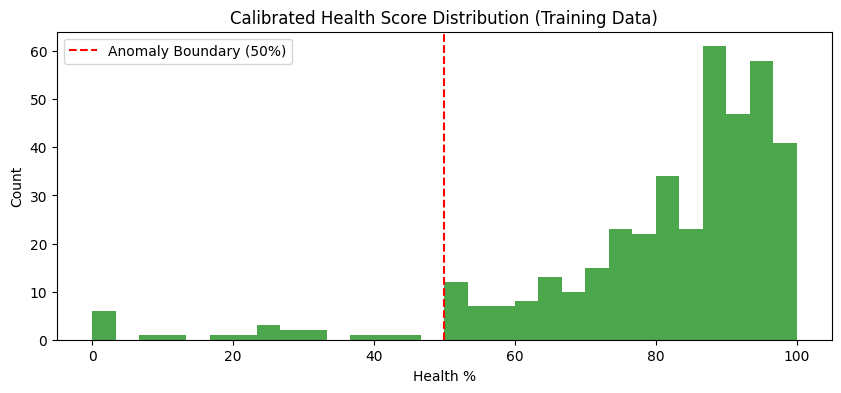

In [12]:
def get_calibrated_scorer(model, X_train_scaled):
    """
    Creates a health scorer calibrated to the training data distribution.

    Mapping:
      Worst observed anomaly (1st percentile) -> 0% Health
      Isolation Forest decision boundary (0.0) -> 50% Health
      Best normal behavior (99th percentile) -> 100% Health
    """
    # Get decision scores from training data
    train_scores = model.decision_function(X_train_scaled)

    # Robust bounds
    max_nice = np.percentile(train_scores, 99)   # Best normal region
    min_anom = np.percentile(train_scores, 1)    # Worst anomaly region

    # Interpolation points
    xp = [min_anom, 0.0, max_nice]   # Score scale
    fp = [0, 50, 100]                # Health scale

    print(f"[System Calibration]")
    print(f"  0% Health at score ≈ {min_anom:.4f}")
    print(f"  50% Health at decision boundary (0.0)")
    print(f"  100% Health at score ≈ {max_nice:.4f}")

    def calculate_health(X_input):
        raw_scores = model.decision_function(X_input)
        # Linear interpolation with clamping
        health = np.interp(raw_scores, xp, fp, left=0, right=100)
        return health

    return calculate_health


# Initialize Health Scorer
calculate_health_score = get_calibrated_scorer(model, X_scaled)

# Compute health for training data
train_health = calculate_health_score(X_scaled)

# Visualization
plt.figure(figsize=(10, 4))
plt.hist(train_health, bins=30, color='green', alpha=0.7)
plt.title("Calibrated Health Score Distribution (Training Data)")
plt.xlabel("Health %")
plt.ylabel("Count")
plt.axvline(x=50, color='red', linestyle='--', label="Anomaly Boundary (50%)")
plt.legend()
plt.show()


## 4. Synthetic Stress Testing (Simulated Faults)
We inject faults to verify the system detects them.

In [13]:
def generate_stress_data(base_data, fault_type="none", intensity=1.5):
    df = base_data.copy()

    if fault_type == "overheat":
        df['temperature'] += 15 * (intensity - 1)

    elif fault_type == "vibration_imbalance":
        df['vibration'] += 0.3 * (intensity - 1)

    elif fault_type == "voltage_sag":
        df['current'] += 1.5 * (intensity - 1)

    elif fault_type == "combined":
        df['temperature'] += 10
        df['vibration'] += 0.4

    return df


# Create test set: 100 Normal, 50 Overheat, 50 High Vibration
test_normal = data.sample(100, random_state=1).reset_index(drop=True)
test_overheat = generate_stress_data(data.sample(50, random_state=2), "overheat", 1.8)
test_vibration = generate_stress_data(data.sample(50, random_state=3), "vibration_imbalance", 2.5)

# Combine
test_data = pd.concat([test_normal, test_overheat, test_vibration]).reset_index(drop=True)
test_labels = [0]*100 + [1]*50 + [1]*50 # 0=Normal, 1=Anomaly

print("Test Data Generated:", test_data.shape)

Test Data Generated: (200, 5)


## 5. Industrial Insights & Decision Making
Here we implement the actionable functions:
1. **Root Cause Analysis (Contribution)**
2. **Risk Classification**
3. **Alerting**

In [14]:
# Store baseline statistics from normal training data
baseline_mean = data.mean()
baseline_std = data.std()
feature_names = data.columns.tolist()


def analyze_sensor_contribution(sample):
    """
    Calculates Z-score deviation of a sample from normal baseline.
    Returns sensors ranked by contribution to anomaly.
    """
    # Convert to Series if needed
    if isinstance(sample, (np.ndarray, list)):
        sample = pd.Series(sample, index=feature_names)

    # Compute Z-scores relative to baseline
    z_scores = (sample - baseline_mean) / baseline_std
    contributions = dict(zip(feature_names, np.abs(z_scores)))

    # Sort sensors by highest deviation
    sorted_contrib = sorted(contributions.items(), key=lambda item: item[1], reverse=True)
    return sorted_contrib


def classify_risk(health_score):
    """
    Classifies risk level based on health percentage.
    """
    if health_score > 80:
        return "NORMAL"
    elif 50 < health_score <= 80:
        return "WARNING"
    else:
        return "CRITICAL"

def generate_alert(risk, health, top_factors):
    """
    Generates an industrial-style alert message.
    """
    if risk == "NORMAL":
        return f"[OK] System Healthy (Score: {health:.1f}%)"
    
    # Construct alert message with all contributing factors
    alert = f"[{risk}] Action Required! Health: {health:.1f}% | "
    
    contributors = []
    for factor, deviation in top_factors:
        # Include factors with significant deviation (e.g., > 1.5 sigma)
        if deviation > 1.5:
            contributors.append(f"{factor.upper()} (Deviation: {deviation:.2f}σ)")
            
    # Fallback: if no factor > 1.5, show at least the top one
    if not contributors and top_factors:
        primary_cause, primary_dev = top_factors[0]
        contributors.append(f"{primary_cause.upper()} (Deviation: {primary_dev:.2f}σ)")
        
    alert += " | ".join(contributors)
    
    return alert


## 6. Real-Time Simluation & Monitoring Loop
We simulate a real-time stream of data and process it.

In [15]:
# Scale entire test set
test_data_scaled = scaler.transform(test_data)

# Calculate Health Scores
scores = calculate_health_score(test_data_scaled)

# Simulation Loop
history = []

print("--- REAL-TIME MONITORING LOG ---")
for i in range(len(test_data)):

    # Simulated periodic check
    if i % 25 == 0:
        current_health = scores[i]
        risk_level = classify_risk(current_health)

        if risk_level != "NORMAL":
            top_factors = analyze_sensor_contribution(test_data.iloc[i])
            alert = generate_alert(risk_level, current_health, top_factors)
            print(f"Time {i}: {alert}")
        else:
            print(f"Time {i}: [INFO] Running Optimal. Health: {current_health:.1f}%")

    history.append(scores[i])

print("--- MONITORING END ---")


--- REAL-TIME MONITORING LOG ---
Time 0: [INFO] Running Optimal. Health: 98.9%
Time 25: [WARNING] Action Required! Health: 72.0% | CURRENT (Deviation: 1.93σ)
Time 50: [INFO] Running Optimal. Health: 88.1%
Time 75: [WARNING] Action Required! Health: 54.3% | VIBRATION (Deviation: 4.15σ)
Time 100: [CRITICAL] Action Required! Health: 0.0% | TEMPERATURE (Deviation: 13.21σ) | VIBRATION (Deviation: 4.15σ) | HUMIDITY (Deviation: 2.74σ)
Time 125: [WARNING] Action Required! Health: 68.8% | TEMPERATURE (Deviation: 10.52σ)
Time 150: [WARNING] Action Required! Health: 59.9% | VIBRATION (Deviation: 1.73σ)
Time 175: [INFO] Running Optimal. Health: 80.1%
--- MONITORING END ---


## 7. Trend Visualization
Visualizing the timeline shows exactly when faults started.

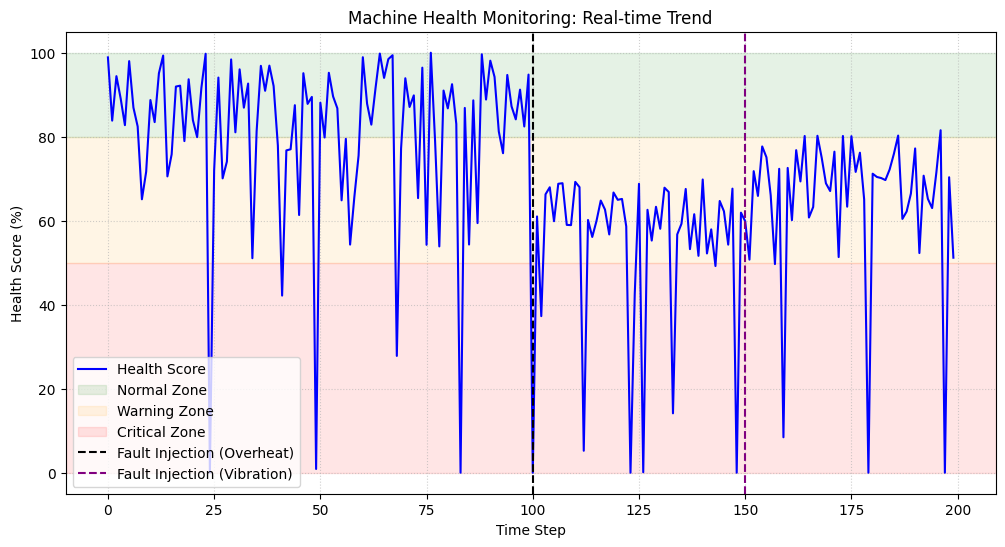

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(history, label="Health Score", color='blue')

# Threshold Zones
plt.axhspan(80, 100, color='green', alpha=0.1, label="Normal Zone")
plt.axhspan(50, 80, color='orange', alpha=0.1, label="Warning Zone")
plt.axhspan(0, 50, color='red', alpha=0.1, label="Critical Zone")

# Dynamic fault markers
plt.axvline(x=len(test_normal), color='black', linestyle='--', label="Fault Injection (Overheat)")
plt.axvline(x=len(test_normal) + len(test_overheat), color='purple', linestyle='--', label="Fault Injection (Vibration)")

plt.title("Machine Health Monitoring: Real-time Trend")
plt.xlabel("Time Step")
plt.ylabel("Health Score (%)")
plt.legend(loc='lower left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


In [17]:
# import pandas as pd

# # 1. Define your new sensor reading
# new_sample = {
#     'temperature': 85.5,
#     'humidity': 52.0,
#     'gas': 122.0,
#     'current': 4.6,
#     'vibration': 0.38
# }

# # 2. Create DataFrame and Scale
# features = ['temperature', 'humidity', 'gas', 'current', 'vibration']
# sample_df = pd.DataFrame([new_sample], columns=features)
# sample_scaled = scaler.transform(sample_df)

# # 3. Calculate Health Score
# health_score_array = calculate_health_score(sample_scaled)
# health_score = health_score_array[0]  # <--- FIX: Get the single value out of the array

# risk = classify_risk(health_score)

# print(f"Input: {new_sample}")
# print(f"Health Score: {health_score:.1f}%")
# print(f"Status: {risk}")

# # 4. Check details
# if risk != "NORMAL":
#     top_factors = analyze_sensor_contribution(sample_df.iloc[0], scaler)
#     alert = generate_alert(risk, health_score, top_factors)
#     print(f"Alert: {alert}")